# Import Modules for notebook
### Better import all modules required

In [1]:
# import Google earth engine module
import ee

#Authenticate the Google earth engine with google account
# First firt setup only, no need to run this after first run


# ee.Authenticate()

# for normal/regular use for authorization
# this is required regularly
ee.Initialize()


#Pandas modules to interact data
import numpy as np
import pandas as pd

# Define indicators of interest here
### for this blog, i will demonstrate NDVI and EVI for Sentinel-2 image

In [2]:
# compute NDVI from NIR and red band in sentinel -2 image
# For other satellite image, please change the band information accordingly

def getNDVI(image):
    
    # Normalized difference vegetation index (NDVI)
    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    image = image.addBands(ndvi)

    return(image)

### EVI computation from Sentinel-2 image

In [3]:
# compute EVI from NIR and red band in sentinel -2 image
# For other satellite image, please change the band information accordingly

def getEVI(image):
    # Compute the EVI using an expression.
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8').divide(10000),
            'RED': image.select('B4').divide(10000),
            'BLUE': image.select('B2').divide(10000)
        }).rename("EVI")

    image = image.addBands(EVI)

    return(image)

### Date parameterfor image
#### It is most important part for time series study

In [4]:
# manage the date formating as per your requirements
# Mine is in format of YYYYMMdd
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

## Filter the imagery for your desired timeframe and other parameters
## I have limited the filters for sample only

In [21]:
Sentinel_data = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate("2021-01-01","2021-08-31") \
    .map(getNDVI).map(getEVI).map(addDate)

### Import your point samples here
### Modify as per your requirements

In [22]:
plot_df = pd.read_excel('data/sample_plot_points_random.xlsx')
plot_df

,id,State,District,Municipality,ward,latitude,longitude
0,1,State_5,Banke,Raptisonari,6,28.060254,81.753436
1,2,State_5,Banke,Raptisonari,6,28.059890,81.753710
2,3,State_5,Banke,Raptisonari,7,28.024677,81.761715
3,4,State_5,Banke,Raptisonari,7,28.023747,81.761789
4,5,State_5,Banke,Raptisonari,7,28.020942,81.759941
...,...,...,...,...,...,...,...
96,97,State_3,Chitwan,Khairahani,8,27.627604,84.572842
97,98,State_3,Chitwan,Madi,3,27.452450,84.312578
98,99,State_3,Chitwan,Madi,5,27.438988,84.309903
99,100,State_3,Chitwan,Madi,5,27.450784,84.319062


## Convert the pandas dataframe into Google Earth Engine (GEE) Feature Collection

In [23]:
features=[]
for index, row in plot_df.iterrows():
#     print(dict(row))
#     construct the geometry from dataframe
    poi_geometry = ee.Geometry.Point([row['longitude'], row['latitude']])
#     print(poi_geometry)
#     construct the attributes (properties) for each point 
    poi_properties = dict(row)
#     construct feature combining geometry and properties
    poi_feature = ee.Feature(poi_geometry, poi_properties)
#     print(poi_feature)
    features.append(poi_feature)

# final Feature collection assembly
ee_fc = ee.FeatureCollection(features) 
ee_fc.getInfo()

{'type': 'FeatureCollection',
 'columns': {'District': 'String',
  'Municipality': 'String',
  'State': 'String',
  'id': 'Integer',
  'latitude': 'Float',
  'longitude': 'Float',
  'system:index': 'String',
  'ward': 'Integer'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [81.75343635, 28.06025397]},
   'id': '0',
   'properties': {'District': 'Banke',
    'Municipality': 'Raptisonari',
    'State': 'State_5',
    'id': 1,
    'latitude': 28.06025397,
    'longitude': 81.75343635,
    'ward': 6}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [81.75371006, 28.05989049]},
   'id': '1',
   'properties': {'District': 'Banke',
    'Municipality': 'Raptisonari',
    'State': 'State_5',
    'id': 2,
    'latitude': 28.05989049,
    'longitude': 81.75371006,
    'ward': 6}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [81.76171468, 28.02467743]},
   'id': '2',
   'properties': {'District': 'Banke',
    'M

## Extract the raster values for each features 
## We will use sampleRegions function from ee.image and apply to image collection

In [24]:
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = ee_fc, # feature collection here
        scale = 10 # Cell size of raster
    )
    return feature


### Apply raster extraction functions over image collection
#### sampleRegions returns feature collection with image values
#### then we have collection of feature collection which is then flattened to obtain final feature collection
#### Finally feature collection is converted to CSV 

In [25]:
results = Sentinel_data.filterBounds(ee_fc).select('NDVI', 'EVI').map(addDate).map(rasterExtraction).flatten()

#### Verify that output is as per your requirments

In [10]:
sample_result = results.first().getInfo()
sample_result

{'type': 'Feature',
 'geometry': None,
 'id': '20210301T045721_20210301T050505_T45RTL_96_0',
 'properties': {'District': 'Chitwan',
  'EVI': 0.15375378511015977,
  'Municipality': 'Khairahani',
  'NDVI': 0.17597848176956177,
  'State': 'State_3',
  'date': 20210301,
  'id': 97,
  'latitude': 27.62760382,
  'longitude': 84.57284189,
  'ward': 8}}

# Now we have extracted the raster values, We need to convert feature collection to CSV format.
## We can acheive this in multiple ways, I will illustrate in 3 ways for extraction


In [26]:
# extract the properties column from feature collection
# column order may not be as our sample data order
columns = list(sample_result['properties'].keys())
print(columns)


# Order data column as per sample data
# You can modify this for better optimization
column_df = list(plot_df.columns)
column_df.extend(['NDVI', 'EVI', 'date'])
print(column_df)





['District', 'EVI', 'Municipality', 'NDVI', 'State', 'date', 'id', 'latitude', 'longitude', 'ward']
['id', 'State', 'District', 'Municipality', 'ward', 'latitude', 'longitude', 'NDVI', 'EVI', 'date']


# Method 1: Feature collection to pandas dataframe 

In [27]:
nested_list = results.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
data = nested_list.getInfo()
data

[[16,
  'State_7',
  'Kailali',
  'Dhangadhi',
  4,
  28.7248938,
  80.57384028,
  0.5313551425933838,
  0.5568021541223235,
  20210101],
 [17,
  'State_7',
  'Kailali',
  'Godawari',
  1,
  28.79824702,
  80.5877749,
  0.4580320715904236,
  0.4572558373085614,
  20210101],
 [18,
  'State_7',
  'Kailali',
  'Godawari',
  6,
  28.79731508,
  80.58724552,
  0.3980271816253662,
  0.417809369228186,
  20210101],
 [19,
  'State_7',
  'Kailali',
  'Godawari',
  6,
  28.79666717,
  80.58602128,
  0.47602275013923645,
  0.49086439068000226,
  20210101],
 [20,
  'State_7',
  'Kailali',
  'Dhangadhi',
  6,
  28.72662138,
  80.59343537,
  0.44736066460609436,
  0.44783609848261197,
  20210101],
 [21,
  'State_7',
  'Kailali',
  'Dhangadhi',
  6,
  28.73003014,
  80.59347903,
  0.599018394947052,
  0.7036609974055924,
  20210101],
 [22,
  'State_7',
  'Kailali',
  'Dhangadhi',
  6,
  28.73086155,
  80.59359825,
  0.634120762348175,
  0.7408770315854034,
  20210101],
 [23,
  'State_7',
  'Kailali',

In [28]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(data, columns=column_df)
# we obtain the data frame as per our demand
df

,id,State,District,Municipality,ward,latitude,longitude,NDVI,EVI,date
0,16,State_7,Kailali,Dhangadhi,4,28.724894,80.573840,0.531355,0.556802,20210101
1,17,State_7,Kailali,Godawari,1,28.798247,80.587775,0.458032,0.457256,20210101
2,18,State_7,Kailali,Godawari,6,28.797315,80.587246,0.398027,0.417809,20210101
3,19,State_7,Kailali,Godawari,6,28.796667,80.586021,0.476023,0.490864,20210101
4,20,State_7,Kailali,Dhangadhi,6,28.726621,80.593435,0.447361,0.447836,20210101
...,...,...,...,...,...,...,...,...,...,...
6338,54,State_7,Kailali,Dhangadhi,0,28.725532,80.594245,-0.005107,-0.043895,20210829
6339,55,State_7,Kailali,Dhangadhi,6,28.730705,80.595954,-0.005852,-0.048757,20210829
6340,56,State_7,Kailali,Dhangadhi,14,28.670453,80.596159,-0.004151,-0.034572,20210829
6341,57,State_7,Kailali,Dhangadhi,9,28.669071,80.598716,-0.003691,-0.031109,20210829


# Method 2: Direct download Feature collection to CSV via URL link

In [31]:
url_csv = results.getDownloadURL('csv')
# click the link below, this will download CSV directly to your local device
# You can use this url and download with python request module, I will leave that to you
url_csv


'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/tables/470c6c2fd2574a916639623468a9a075-84785f7eeb03255dddca92df5a66bd89:getFeatures'

# Method 3: Download feature collection as CSV to Google Drive

In [32]:
task = ee.batch.Export.table.toDrive(**{
  'collection': results,
  'description':'vectorsToDriveExample',
  'fileFormat': 'csv'
})
task.start()

In [33]:
import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).
Polling for task (id: RY5HOLQ5DJOY6F6M5HOU2ZC6).


## Data visualization of results:
#### I will go on details for visualization on the next blog post

In [30]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# I will plot line plot for single point only for now.
# I will cover detail analaysis in next plot
df_filtered = df[df['id']==1]
df_filtered['date'] = pd.to_datetime(df_filtered['date'], format='%Y%m%d')
df_filtered

<ipython-input-41-7cae63017e3c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,State,District,Municipality,ward,latitude,longitude,NDVI,EVI,date
59,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.284138,0.379304,2021-01-03
190,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.431592,0.434558,2021-01-08
345,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.015804,0.050612,2021-01-13
478,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.334231,0.307964,2021-01-18
612,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.134952,0.227614,2021-01-23
745,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.018991,0.073199,2021-01-28
879,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.180309,0.172078,2021-02-02
1013,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.199880,0.174642,2021-02-07
1147,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.159682,0.209231,2021-02-12
1281,1,State_5,Banke,Raptisonari,6,28.060254,81.753436,0.251852,0.211121,2021-02-17


In [45]:
# Using plotly.express
import plotly.express as px

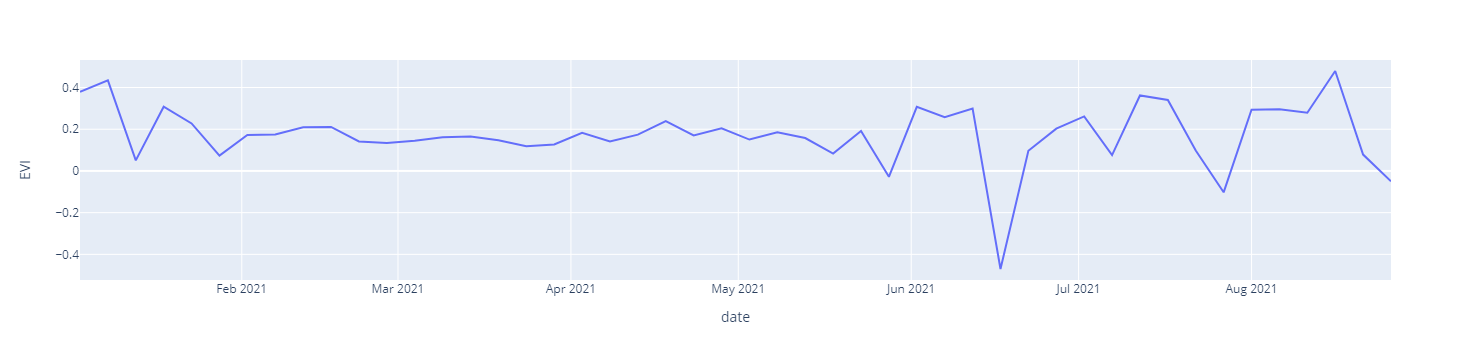

In [46]:
df = px.data.stocks()
fig = px.line(df_filtered, x='date', y="EVI")
fig.show()

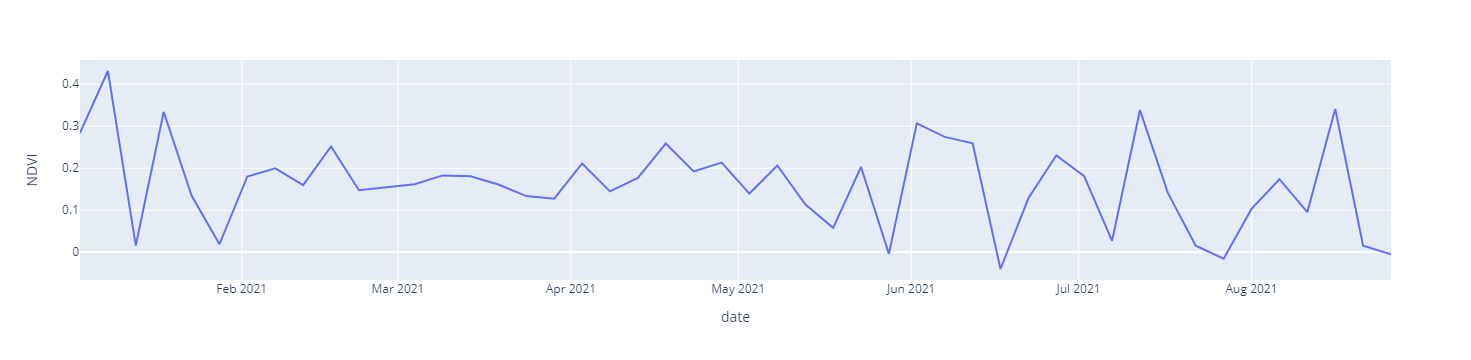

In [47]:
df = px.data.stocks()
fig = px.line(df_filtered, x='date', y="NDVI")
fig.show()